# Import Libraries and Setup

In [1]:
from ANNarchy import * 
import math
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.integrate import simps
from scipy.signal import hilbert
from neurodsp.filt import filter_signal
import warnings
warnings.filterwarnings("ignore")

# chenge Dd to get different rates of the external input for D2
Dd = 0.9

dt_value = 0.02
#dt_value = 0.1
t_f = 6000
setup(dt=dt_value, structural_plasticity= True, method='rk4') 

plt.rcParams.update({'font.size': 20})
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

ANNarchy 4.7 (4.7.2.4) on linux (posix).


# Build the BG Network

In [2]:
STN = Neuron(
    parameters="""
        C_m = 60 * 1e-3         : population 
        G_l = 10.0 * 1e-3       : population        
        E_l = -80.2             : population
        delta_T = 16.2          : population
        V_th = -64.0            : population
        E_ex = 0.0              : population
        E_in = -84.0            : population
        I_e = 5.0 * 1e-3        : population
        tau_ex = 4.0            : population
        tau_in = 8.0            : population
        tau_w = 333.0           : population
        a = 0.0 * 1e-3          : population
        b = 0.05 * 1e-3         : population
        V_peak = 15.0           : population
        V_reset = -70.0         : population
    """,
       equations="""
        prev_v = v
        prev_w = w
        C_m * dv/dt = -G_l * (v - E_l) + G_l * delta_T * func_aux(v, V_th, delta_T, V_peak) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e  
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in
        tau_w * dw/dt = - w + a * (v - E_l)
    """,
    spike = "(v>V_peak) or (abs(v-prev_v)>150)",
    reset = """               
               w = temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) + b
               v = V_reset
    """,
    functions = """
        func_aux(v, V_th, delta_T, V_peak) = if v>1100: exp((1100 - V_th)/delta_T) else: exp((v - V_th)/delta_T)
        temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) = if (abs(v-prev_v)>150) : prev_w + (dt/tau_w) * (a * (V_peak- E_l) - prev_w) else: w
    """,
    refractory = 0.0
)

In [3]:
GPe_TA = Neuron(
       parameters="""
        C_m = 60 * 1e-3         : population 
        G_l = 1.0 * 1e-3        : population        
        E_l = -55.1             : population
        delta_T = 2.55          : population
        V_th = -54.7            : population
        E_ex = 0.0              : population
        E_in = -65.0            : population
        I_e = 1.0 * 1e-3        : population
        tau_ex = 10.0           : population
        tau_in = 5.5            : population
        tau_w = 20.0            : population
        a = 2.5 * 1e-3          : population
        b = 105.0 * 1e-3        : population
        V_peak = 15.0           : population
        V_reset = -60.0         : population
    """,
       equations="""
        prev_v = v
        prev_w = w
        C_m * dv/dt = -G_l * (v - E_l) + G_l * delta_T * func_aux(v, V_th, delta_T, V_peak) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e  
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in
        tau_w * dw/dt = - w + a * (v - E_l)
    """,
    spike = "(v>V_peak) or (abs(v-prev_v)>150)",
    reset = """               
               w = temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) + b
               v = V_reset
    """,
    functions = """
        func_aux(v, V_th, delta_T, V_peak) = if v>1100: exp((1100 - V_th)/delta_T) else: exp((v - V_th)/delta_T)
        temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) = if (abs(v-prev_v)>150) : prev_w + (dt/tau_w) * (a * (V_peak- E_l) - prev_w) else: w
    """,
    refractory = 0.0
)

In [4]:
GPe_TI = Neuron(
       parameters="""
        C_m = 40 * 1e-3         : population 
        G_l = 1.0 * 1e-3        : population        
        E_l = -55.1             : population
        delta_T = 1.7           : population
        V_th = -54.7            : population
        E_ex = 0.0              : population
        E_in = -65.0            : population
        I_e = 12.0 * 1e-3       : population
        tau_ex = 10.0           : population
        tau_in = 7.0            : population
        tau_w = 20.0            : population
        a = 2.5 * 1e-3          : population
        b = 70.0 * 1e-3         : population
        V_peak = 15.0           : population
        V_reset = -60.0         : population
    """,
       equations="""
        prev_v = v
        prev_w = w
        C_m * dv/dt = -G_l * (v - E_l) + G_l * delta_T * func_aux(v, V_th, delta_T, V_peak) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e  
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in
        tau_w * dw/dt = - w + a * (v - E_l)
    """,
    spike = "(v>V_peak) or (abs(v-prev_v)>150)",
    reset = """               
               w = temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) + b
               v = V_reset
    """,
    functions = """
        func_aux(v, V_th, delta_T, V_peak) = if v>1100: exp((1100 - V_th)/delta_T) else: exp((v - V_th)/delta_T)
        temp_w(w, v, prev_v, prev_w, tau_w, a, V_peak, E_l, b, dt) = if (abs(v-prev_v)>150) : prev_w + (dt/tau_w) * (a * (V_peak- E_l) - prev_w) else: w
    """,
    refractory = 0.0
)

In [5]:
FSN = Neuron(
   parameters="""
        C_m = 80.0 * 1e-3       : population       
        E_l = -80.0             : population
        V_th = -50.0            : population
        E_ex = 0.0              : population
        E_in = -74.0            : population
        I_e = 0.0 * 1e-3        : population
        tau_ex = 12.0           : population
        tau_in = 10.0           : population
        tau_w = 5.0             : population
        a = 0.025 * 1e-3        : population
        b = 0.0 * 1e-3          : population
        V_peak = 25.0           : population
        V_reset = -60.0         : population
        k = 1.0 * 1e-3          : population
        V_b = -55.0             : population  
    """,
   equations="""
        C_m * dv/dt = k * (v - E_l) * (v - V_th) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in         
        tau_w * dw/dt = - w + var_temp(v, V_b, a)      
    """,
    spike = "v > V_peak",
    reset = """v = V_reset
               w += b 
    """,
    functions = """
        var_temp(v, s1, s2) = if s1 > v : s2 * pow((v - s1) , 3) else: 0
    """,
    refractory = 0.0
)  

In [6]:
D2 = Neuron(
   parameters="""
        C_m = 15.2 * 1e-3       : population       
        E_l = -80.0             : population
        V_th = -29.7            : population
        E_ex = 0.0              : population
        E_in = -74.0            : population
        I_e = 0.0 * 1e-3        : population
        tau_ex = 12.0           : population
        tau_in = 10.0           : population
        tau_w = 100.0           : population
        a = -20.0 * 1e-3        : population
        b = 91.0 * 1e-3         : population
        V_peak = 40.0           : population
        V_reset = -60.0         : population
        k = 1.0 * 1e-3          : population
    """,
   equations="""
        C_m * dv/dt = k * (v - E_l) * (v - V_th) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in
        tau_w * dw/dt = - w + a * (v - E_l)
    """,
    spike = "v > V_peak",
    reset = """v = V_reset
               w += b 
    """,
    refractory = 0.0
)

In [7]:
D1 = Neuron(
   parameters="""
        C_m = 15.2 * 1e-3       : population       
        E_l = -78.2             : population
        V_th = -29.7            : population
        E_ex = 0.0              : population
        E_in = -74.0            : population
        I_e = 0.0 * 1e-3        : population
        tau_ex = 12.0           : population
        tau_in = 10.0           : population
        tau_w = 100.0           : population
        a = -20.0 * 1e-3        : population
        b = 67.0 * 1e-3         : population
        V_peak = 40.0           : population
        V_reset = -60.0         : population
        k = 1.0 * 1e-3          : population
    """,
   equations="""        
        C_m * dv/dt = k * (v - E_l) * (v - V_th) - w + g_ex * (E_ex - v) + g_in * (E_in - v ) + I_e
        tau_ex * dg_ex/dt = - g_ex
        tau_in * dg_in/dt = - g_in
        tau_w * dw/dt = - w + a * (v - E_l)
    """,
    spike = "v > V_peak",
    reset = """v = V_reset
               w += b 
    """,
    refractory = 0.0
)

In [8]:
P_STN = Population(geometry=408, neuron=STN)
P_GPe_TA = Population(geometry=264, neuron=GPe_TA)
P_GPe_TI = Population(geometry=780, neuron=GPe_TI)
P_FSN = Population(geometry=420, neuron=FSN)
P_D2 = Population(geometry=6000, neuron=D2)
P_D1 = Population(geometry=6000, neuron=D1)

P_ext_STN = PoissonPopulation(408, rates=0.5 * 1e3)
P_ext_GPe_TA = PoissonPopulation(264, rates=0.17 * 1e3)
P_ext_GPe_TI = PoissonPopulation(780, rates=600)
P_ext_FSN = PoissonPopulation(420, rates=0.9444 * 1e3)

# Dd (the dopamine depletion parameter which was defined in the beginning) changes the rate of external inputs to D2
P_ext_D2 = PoissonPopulation(6000, rates=(0.9729278004599998/0.9) * Dd * 1e3 * 1.11)

P_ext_D1 = PoissonPopulation(6000, rates=1.12 * 1e3 * 1.14)

In [9]:
P_STN.v = Normal(-80.2, 0)
P_GPe_TA.v = Normal(-55.1, 0)
P_GPe_TI.v = Normal(-55.1, 0)
P_FSN.v = Normal(-80.0, 0)
P_D2.v = Normal(-80.0, 0)
P_D1.v = Normal(-78.2, 0)

In [10]:
D1toD1 = Projection(pre=P_D1, post=P_D1, target='in')
D1toD1.connect_fixed_probability(weights=0.12 * 1e-3, probability=0.0607, delays=1.7)
#D1toD1.connect_from_file(filename='Connectivity/D1toD1.npz')

D1toD2 = Projection(pre=P_D1, post=P_D2, target='in')
D1toD2.connect_fixed_probability(weights=0.30 * 1e-3, probability=0.0140, delays=1.7)
#D1toD2.connect_from_file(filename='Connectivity/D1toD2.npz')

D2toD1 = Projection(pre=P_D2, post=P_D1, target='in')
D2toD1.connect_fixed_probability(weights=0.36 * 1e-3, probability=0.0653, delays=1.7)
#D2toD1.connect_from_file(filename='Connectivity/D2toD1.npz')

D2toD2 = Projection(pre=P_D2, post=P_D2, target='in')
D2toD2.connect_fixed_probability(weights=0.25 * 1e-3, probability=0.0840, delays=1.7)
#D2toD2.connect_from_file(filename='Connectivity/D2toD2.npz')

D2toGPe_TI = Projection(pre=P_D2, post=P_GPe_TI, target='in')
D2toGPe_TI.connect_fixed_probability(weights=1.28 * 1e-3, probability=0.0833, delays=7.0)
#D2toGPe_TI.connect_from_file(filename='Connectivity/D2toGPe_TI.npz')

FSNtoD1 = Projection(pre=P_FSN, post=P_D1, target='in')
FSNtoD1.connect_fixed_probability(weights=6.6 * 1e-3, probability=0.0381, delays=1.7)
#FSNtoD1.connect_from_file(filename='Connectivity/FSNtoD1.npz')

FSNtoFSN = Projection(pre=P_FSN, post=P_FSN, target='in')
FSNtoFSN.connect_fixed_probability(weights=0.5 * 1e-3, probability=0.0238, delays=1.0)
#FSNtoFSN.connect_from_file(filename='Connectivity/FSNtoFSN.npz')

FSNtoD2 = Projection(pre=P_FSN, post=P_D2, target='in')
FSNtoD2.connect_fixed_probability(weights=4.8 * 1e-3, probability=0.0262, delays=1.7)
#FSNtoD2.connect_from_file(filename='Connectivity/FSNtoD2.npz')

GPe_TItoGPe_TI = Projection(pre=P_GPe_TI, post=P_GPe_TI, target='in')
GPe_TItoGPe_TI.connect_fixed_probability(weights=1.1 * 1e-3, probability=0.0321, delays=1.8)
#GPe_TItoGPe_TI.connect_from_file(filename='Connectivity/GPe_TItoGPe_TI.npz')

GPe_TItoGPe_TA = Projection(pre=P_GPe_TI, post=P_GPe_TA, target='in')
GPe_TItoGPe_TA.connect_fixed_probability(weights=0.35 * 1e-3, probability=0.0321, delays=1.0)
#GPe_TItoGPe_TA.connect_from_file(filename='Connectivity/GPe_TItoGPe_TA.npz')

GPe_TItoFSN = Projection(pre=P_GPe_TI, post=P_FSN, target='in')
GPe_TItoFSN.connect_fixed_probability(weights=1.6 * 1e-3, probability=0.0128, delays=7.0)
#GPe_TItoFSN.connect_from_file(filename='Connectivity/GPe_TItoFSN.npz')

GPe_TItoSTN = Projection(pre=P_GPe_TI, post=P_STN, target='in')
GPe_TItoSTN.connect_fixed_probability(weights=0.08 * 1e-3, probability=0.0385, delays=1.0)
#GPe_TItoSTN.connect_from_file(filename='Connectivity/GPe_TItoSTN.npz')

GPe_TAtoD1 = Projection(pre=P_GPe_TA, post=P_D1, target='in')
GPe_TAtoD1.connect_fixed_probability(weights=0.35 * 1e-3, probability=0.0379, delays=7.0)
#GPe_TAtoD1.connect_from_file(filename='Connectivity/GPe_TAtoD1.npz')


GPe_TAtoD2 = Projection(pre=P_GPe_TA, post=P_D2, target='in')
GPe_TAtoD2.connect_fixed_probability(weights=0.61 * 1e-3, probability=0.0379, delays=7.0)
#GPe_TAtoD2.connect_from_file(filename='Connectivity/GPe_TAtoD2.npz')
                                
GPe_TAtoFSN = Projection(pre=P_GPe_TA, post=P_FSN, target='in')
GPe_TAtoFSN.connect_fixed_probability(weights=1.85 * 1e-3, probability=0.0379, delays=7.0)
#GPe_TAtoFSN.connect_from_file(filename='Connectivity/GPe_TAtoFSN.npz')
                                
GPe_TAtoGPe_TA = Projection(pre=P_GPe_TA, post=P_GPe_TA, target='in')
GPe_TAtoGPe_TA.connect_fixed_probability(weights=0.35 * 1e-3, probability=0.0189, delays=1.0)
#GPe_TAtoGPe_TA.connect_from_file(filename='Connectivity/GPe_TAtoGPe_TA.npz')
                                
GPe_TAtoGPe_TI = Projection(pre=P_GPe_TA, post=P_GPe_TI, target='in')
GPe_TAtoGPe_TI.connect_fixed_probability(weights=1.2 * 1e-3, probability=0.0189, delays=1.0)
#GPe_TAtoGPe_TI.connect_from_file(filename='Connectivity/GPe_TAtoGPe_TI.npz')
                                
STNtoGPe_TA = Projection(pre=P_STN, post=P_GPe_TA, target='ex')
STNtoGPe_TA.connect_fixed_probability(weights=0.13 * 1e-3, probability=0.0735, delays=2.0)
#STNtoGPe_TA.connect_from_file(filename='Connectivity/STNtoGPe_TA.npz')

STNtoGPe_TI = Projection(pre=P_STN, post=P_GPe_TI, target='ex')
STNtoGPe_TI.connect_fixed_probability(weights=0.42 * 1e-3, probability=0.0735, delays=2.0)
#STNtoGPe_TI.connect_from_file(filename='Connectivity/STNtoGPe_TI.npz')

exttoSTN = Projection(P_ext_STN, P_STN, 'ex')
exttoSTN.connect_one_to_one(weights=Uniform(0.2 * 1e-3, 0.3 * 1e-3), delays = 0)
#exttoSTN.connect_from_file(filename='Connectivity/exttoSTN.npz')

exttoGPe_TA = Projection(P_ext_GPe_TA, P_GPe_TA, 'ex')
exttoGPe_TA.connect_one_to_one(weights=Uniform(0.10 * 1e-3, 0.2 * 1e-3), delays = 0)
#exttoGPe_TA.connect_from_file(filename='Connectivity/exttoGPe_TA.npz')

exttoGPe_TI = Projection(P_ext_GPe_TI, P_GPe_TI, 'ex')
exttoGPe_TI.connect_one_to_one(weights=Uniform(0.2 * 1e-3, 0.3 * 1e-3), delays = 0)
#exttoGPe_TI.connect_from_file(filename='Connectivity/exttoGPe_TI.npz')

exttoFSN = Projection(P_ext_FSN, P_FSN, 'ex')
exttoFSN.connect_one_to_one(weights=Uniform(0.45 * 1e-3, 0.55 * 1e-3), delays = 0)
#exttoFSN.connect_from_file(filename='Connectivity/exttoFSN.npz')

exttoD2 = Projection(P_ext_D2, P_D2, 'ex')
exttoD2.connect_one_to_one(weights=Uniform(0.4 * 1e-3, 0.5 * 1e-3), delays = 0)
#exttoD2.connect_from_file(filename='Connectivity/exttoD2.npz')

exttoD1 = Projection(P_ext_D1, P_D1, 'ex')
exttoD1.connect_one_to_one(weights=Uniform(0.4 * 1e-3, 0.5 * 1e-3), delays = 0)
#exttoD1.connect_from_file(filename='Connectivity/exttoD1.npz')

In [11]:
compile()

Compiling ...  OK 


In [12]:
#D1toD1.save_connectivity(filename='Connectivity/D1toD1.npz')
#D1toD2.save_connectivity(filename='Connectivity/D1toD2.npz')
#D2toD1.save_connectivity(filename='Connectivity/D2toD1.npz')
#D2toD2.save_connectivity(filename='Connectivity/D2toD2.npz')
#D2toGPe_TI.save_connectivity(filename='Connectivity/D2toGPe_TI.npz')
#FSNtoD1.save_connectivity(filename='Connectivity/FSNtoD1.npz')
#FSNtoFSN.save_connectivity(filename='Connectivity/FSNtoFSN.npz')
#FSNtoD2.save_connectivity(filename='Connectivity/FSNtoD2.npz')
##GPe_TItoGPe_TI.save_connectivity(filename='Connectivity/GPe_TItoGPe_TI.npz')
#GPe_TItoGPe_TA.save_connectivity(filename='Connectivity/GPe_TItoGPe_TA.npz')
#GPe_TItoFSN.save_connectivity(filename='Connectivity/GPe_TItoFSN.npz')
#GPe_TItoSTN.save_connectivity(filename='Connectivity/GPe_TItoSTN.npz')
#GPe_TAtoD1.save_connectivity(filename='Connectivity/GPe_TAtoD1.npz')
#GPe_TAtoD2.save_connectivity(filename='Connectivity/GPe_TAtoD2.npz')
#GPe_TAtoFSN.save_connectivity(filename='Connectivity/GPe_TAtoFSN.npz')
#GPe_TAtoGPe_TA.save_connectivity(filename='Connectivity/GPe_TAtoGPe_TA.npz')
#GPe_TAtoGPe_TI.save_connectivity(filename='Connectivity/GPe_TAtoGPe_TI.npz')
#STNtoGPe_TA.save_connectivity(filename='Connectivity/STNtoGPe_TA.npz')
#STNtoGPe_TI.save_connectivity(filename='Connectivity/STNtoGPe_TI.npz')
#exttoSTN.save_connectivity(filename='Connectivity/exttoSTN.npz')
#exttoGPe_TA.save_connectivity(filename='Connectivity/exttoGPe_TA.npz')
#exttoGPe_TI.save_connectivity(filename='Connectivity/exttoGPe_TI.npz')
#exttoFSN.save_connectivity(filename='Connectivity/exttoFSN.npz')
#exttoD2.save_connectivity(filename='Connectivity/exttoD2.npz')
#exttoD1.save_connectivity(filename='Connectivity/exttoD1.npz')

# Define Monitors and Simulate the Network

In [13]:
m_STN = Monitor(P_STN, ['spike'])
m_GPe_TA = Monitor(P_GPe_TA, ['spike','v'])
m_GPe_TI = Monitor(P_GPe_TI, ['spike','v'])
m_FSN = Monitor(P_FSN, ['spike'])
m_D2 = Monitor(P_D2, ['spike'])
m_D1 = Monitor(P_D1, ['spike'])

In [14]:
simulate(t_f)

# Extract the Outputs

In [15]:
data_STN = m_STN.get('spike')
data_GPe_TA = m_GPe_TA.get('spike')
data_GPe_TI = m_GPe_TI.get('spike')
data_FSN = m_FSN.get('spike')
data_D2 = m_D2.get('spike')
data_D1 = m_D1.get('spike')

In [16]:
#v_GPe_TA =  m_GPe_TA.get('v')
#v_GPe_TI =  m_GPe_TI.get('v')

# Raster Plots

In [17]:
t_STN, n_STN = m_STN.raster_plot(data_STN)
t_GPe_TA, n_GPe_TA = m_GPe_TA.raster_plot(data_GPe_TA)
t_GPe_TI, n_GPe_TI = m_GPe_TI.raster_plot(data_GPe_TI)
t_FSN, n_FSN = m_FSN.raster_plot(data_FSN)
t_D2, n_D2 = m_D2.raster_plot(data_D2)
t_D1, n_D1 = m_D1.raster_plot(data_D1)

Text(0.5, 1.0, 'STN raster plot')

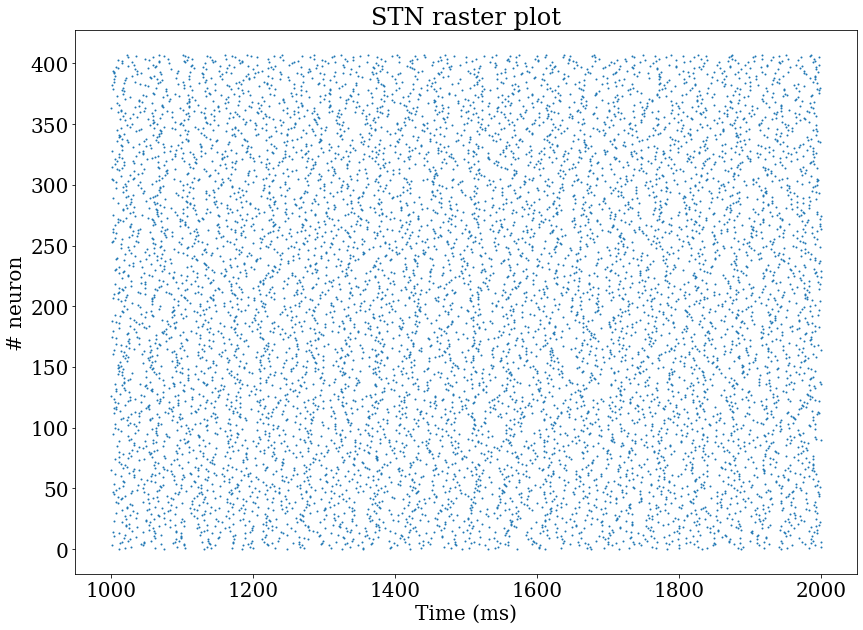

In [18]:
idx_t_STN = np.logical_and(np.array(t_STN)>1000, np.array(t_STN)<2000)
plt.figure(figsize=(14, 10))
plt.plot(t_STN[idx_t_STN], n_STN[idx_t_STN], '.', markersize=2)
plt.xlabel('Time (ms)')
plt.ylabel('# neuron')
plt.title('STN raster plot')

# Firing rates

In [19]:
idx_t_STN = np.argwhere(t_STN>1000)
idx_t_GPe_TA = np.argwhere(t_GPe_TA>1000)
idx_t_GPe_TI = np.argwhere(t_GPe_TI>1000)
idx_t_FSN = np.argwhere(t_FSN>1000)
idx_t_D2 = np.argwhere(t_D2>1000)
idx_t_D1 = np.argwhere(t_D1>1000)

In [20]:
dur = (t_f- 1000)/1000
print('Mean firing rate in STN: ' + str(len(idx_t_STN) / (dur * 408.)) + 'Hz')
print('Mean firing rate in GPe_TA: ' + str(len(idx_t_GPe_TA) / (dur * 264.)) + 'Hz')
print('Mean firing rate in GPe_TI: ' + str(len(idx_t_GPe_TI) / (dur * 780.)) + 'Hz')
print('Mean firing rate in FSN: ' + str(len(idx_t_FSN) / (dur * 420.)) + 'Hz')
print('Mean firing rate in D2: ' + str(len(idx_t_D2) / (dur * 6000.)) + 'Hz')
print('Mean firing rate in D1: ' + str(len(idx_t_D1) / (dur* 6000.)) + 'Hz')

Mean firing rate in STN: 21.826470588235296Hz
Mean firing rate in GPe_TA: 19.23409090909091Hz
Mean firing rate in GPe_TI: 37.24974358974359Hz
Mean firing rate in FSN: 20.386666666666667Hz
Mean firing rate in D2: 1.4176666666666666Hz
Mean firing rate in D1: 1.0616333333333334Hz


# Histograms

In [21]:
t_d1=t_f
t_trans=1000
bin_value = 1
time_hist = np.arange(0, t_d1, bin_value)
nparseg = 1000
fs = 1000/bin_value

fr_STN = m_STN.histogram(data_STN, bins=bin_value)
fr_GPe_TA = m_GPe_TA.histogram(data_GPe_TA, bins=bin_value)
fr_GPe_TI = m_GPe_TI.histogram(data_GPe_TI, bins=bin_value)
fr_FSN = m_FSN.histogram(data_FSN, bins=bin_value)
fr_D2 = m_D2.histogram(data_D2, bins=bin_value)
fr_D1 = m_D1.histogram(data_D1, bins=bin_value)

hist_STN = fr_STN[int(t_trans/bin_value):int(t_d1/bin_value)-1]
f_STN, Pxx_den_STN = signal.welch(hist_STN, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

hist_GPe_TA = fr_GPe_TA[int(t_trans/bin_value):int(t_d1/bin_value)]
f_GPe_TA, Pxx_den_GPe_TA = signal.welch(hist_GPe_TA, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

hist_GPe_TI = fr_GPe_TI[int(t_trans/bin_value):int(t_d1/bin_value)]
f_GPe_TI, Pxx_den_GPe_TI = signal.welch(hist_GPe_TI, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

hist_FSN = fr_FSN[int(t_trans/bin_value):int(t_d1/bin_value)-1]
f_FSN, Pxx_den_FSN = signal.welch(hist_FSN, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

hist_D2 = fr_D2[int(t_trans/bin_value):int(t_d1/bin_value)-1]
f_D2, Pxx_den_D2 = signal.welch(hist_D2, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

hist_D1 = fr_D1[int(t_trans/bin_value):int(t_d1/bin_value)-1]
f_D1, Pxx_den_D1 = signal.welch(hist_D1, fs, nperseg=nparseg, noverlap=int(nparseg/2),nfft=max(30000,nparseg), scaling='density', window='hamming')

# PSDs

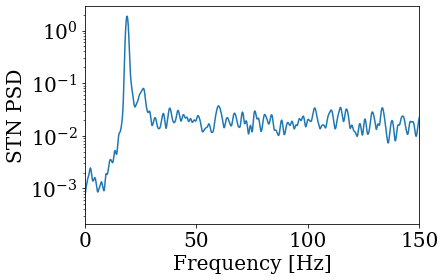

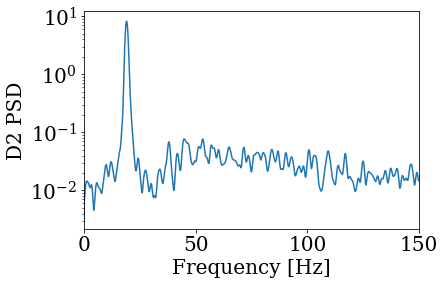

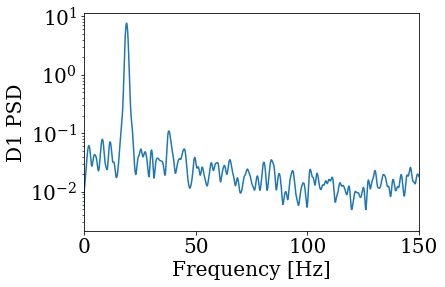

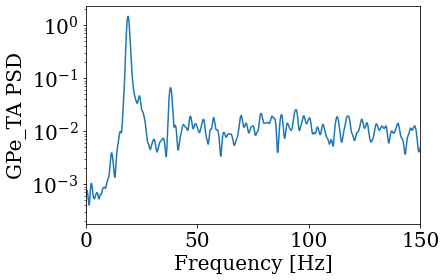

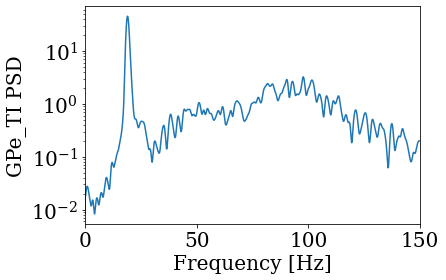

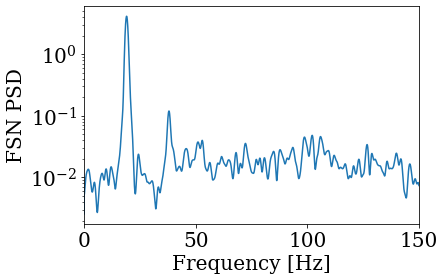

In [22]:
ax = plt.subplot(111)
ax.plot(f_STN, Pxx_den_STN)
plt.xlabel('Frequency [Hz]')
plt.ylabel('STN PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()

ax = plt.subplot(111)
ax.plot(f_D2, Pxx_den_D2)
plt.xlabel('Frequency [Hz]')
plt.ylabel('D2 PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()

ax = plt.subplot(111)
ax.plot(f_D1, Pxx_den_D1)
plt.xlabel('Frequency [Hz]')
plt.ylabel('D1 PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()

ax = plt.subplot(111)
ax.plot(f_GPe_TA, Pxx_den_GPe_TA)
plt.xlabel('Frequency [Hz]')
plt.ylabel('GPe_TA PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()

ax = plt.subplot(111)
ax.plot(f_GPe_TI, Pxx_den_GPe_TI)
plt.xlabel('Frequency [Hz]')
plt.ylabel('GPe_TI PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()

ax = plt.subplot(111)
ax.plot(f_FSN, Pxx_den_FSN)
plt.xlabel('Frequency [Hz]')
plt.ylabel('FSN PSD')
plt.xlim([0,150])
ax.set_yscale('log')
plt.show()